<B>Preface</B><BR>
In this lab, you will implement some of the major algorithms involved in a Convolutional Neural Network(cNN), the most common kind of machine learning for image manipulation. Specifically, you will implement basic image manipulations including grayscaling and thresholding to reduce datadimensionality, a simply 3x3 kernel convolution, and max pooling.  You will be using Python Image Library for this lab.  Test each part on two images, the one I provide and one you find.  
<P>
<B>Part 1: Basic Pixel Operations- Grayscale and Thresholding</B><BR>
You will need to find an image to manipulate, store it on your drive, and mount your drive.  You will also need to import the Python Image Libary. Write two separate functions, one to convert an image to grayscale and a different one to do thresholding.  Use a formula of 0.299r + 0.587g + 
0.114b to calculate the grayscale value of a pixel.  Experiment with different values in the thresholding function to find one that makes the hexagons in the background of the Slither image go away, but preserve the snakes and their food.  What value did you choose?

 

Part 1
Original:


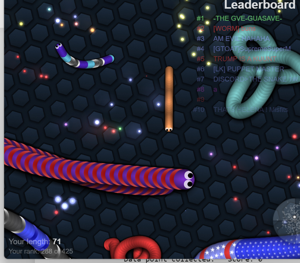

Grayscale:


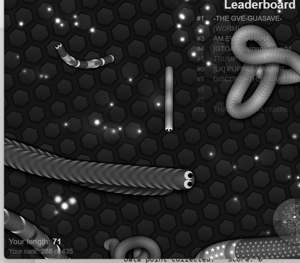

Alternate Grayscale:


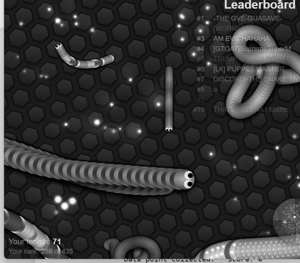

Threshold:
The best threshold value I found to remove the background
hexagons while highlighting the snakes and their food was 60


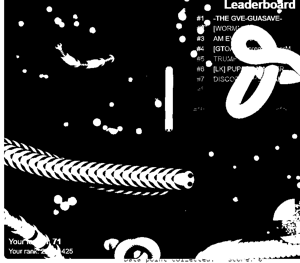

--------------------------------------------------
Part 2
Original:


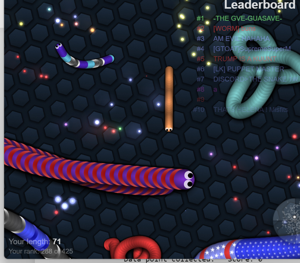

Edge Detection:


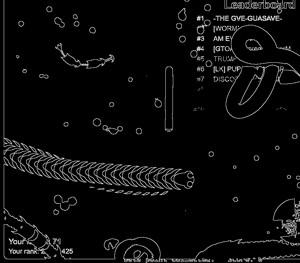

11 x 11 Box Blur:


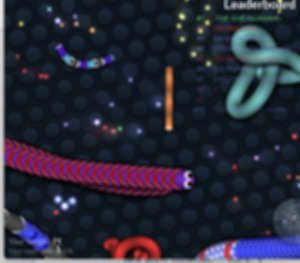

--------------------------------------------------
Part 3
Original:


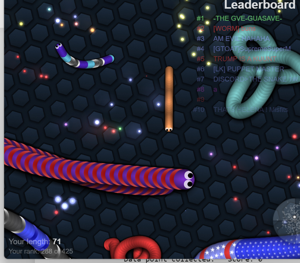

Max Pooling (10%):


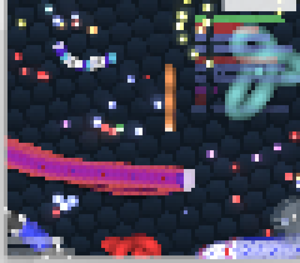

Max Pooling (5%):


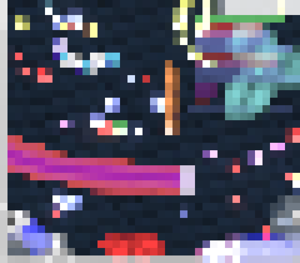

Min Pooling (30%):


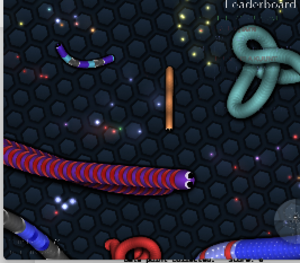

Avg Pooling (50%):


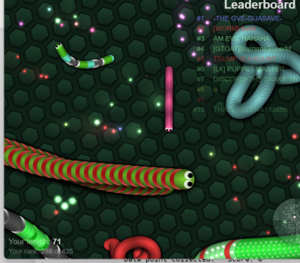

--------------------------------------------------
Create an image using functions from all three parts
[1/5] Original:


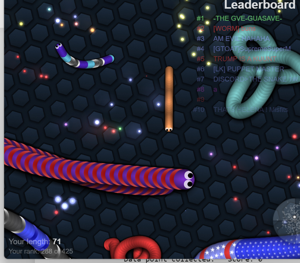

[2/5] Box Blur (7x7):


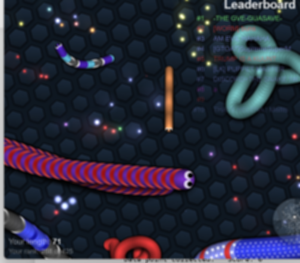

[3/5] Grayscale:


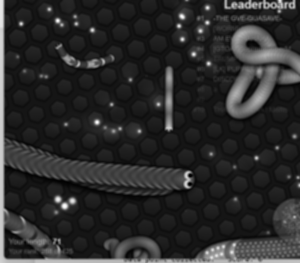

[4/5] Max Pooling (25%):


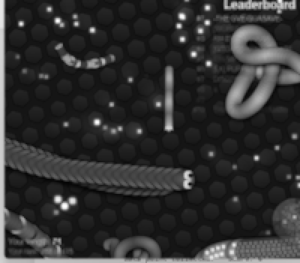

[5/5] Threshold:


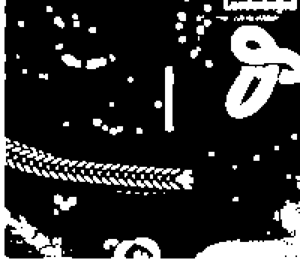

In [39]:
#------------------------------------------------------------------------------#
# This code was written for lab 6 of CST 475,          © Justin Boehnen 2022             
# taught at Oregon Tech by Prof. Cecily Heiner
#------------------------------------------------------------------------------#
from google.colab import drive
from google.colab import output
from PIL import Image
from IPython.display import Image as Img, display
import numpy as np
import math

DIR = '/content/gdrive/My Drive/Colab Notebooks/lab6/{}'

#------------------------------------------------------------------------------#
# Function:   grayscale_image
# Purpose:    This function converts an image to its grayscale representation
# Args:       img       PIL image to convert to grayscale
#             r_weight  [optional] weight of red channel in grayscale image
#             g_weight  [optional] weight of green channel in grayscale image
#             b_weight  [optional] weight of blue channel in grayscale image
# Return:     A grayscale copy of img
#------------------------------------------------------------------------------#
def grayscale_image(img, r_weight = 0.299, g_weight=0.587, b_weight=0.114):
  _img = img.copy()  
  width, height = img.size
  for xx in range(width):
      for yy in range(height):
        r, g, b = _img.getpixel((xx, yy))
        gray = round((r * r_weight) + (g * g_weight) + (b * b_weight))
        _img.putpixel((xx, yy), (gray, gray, gray))
  return _img

#------------------------------------------------------------------------------#
# Function:   threshold_image
# Purpose:    This function converts an image to its thresholded representation.
#             Threshold image contains only black and white pixels.
# Args:       img         image to threshold
#             threshold   0-255 any pixel that has an intensity less than this
#                         value will be converted to black, all others to white.
# Return:     A thresholded copy of img
#------------------------------------------------------------------------------#
def threshold_image(img, threshold):
  _img = grayscale_image(img)
  width, height = img.size
  for xx in range(width):
    for yy in range(height):
      r, g, b = _img.getpixel((xx, yy))
      intensity = (r + g + b)/3
      if(intensity < threshold):
        _img.putpixel((xx, yy), (0, 0, 0))
      else:
        _img.putpixel((xx, yy), (255, 255, 255))
  return _img

def print_line(len, pattern):
  for i in range(len):
    print(pattern, end = '')
  print('')

# this function will run a demonstration of part 1 required functionality
def part1():
  size = 300,300
  img = Image.open(DIR.format('slitherScreenShot.png'))
  gray1 = grayscale_image(img)
  gray2 = grayscale_image(img, 0.25, 0.1 , 0.65)
  thresh = threshold_image(img, 60)
  print("Part 1")

  print("Original:")
  img.thumbnail(size, resample=Image.BICUBIC)
  img.save('part1.png')
  display(Img('part1.png'))

  print("Grayscale:")
  gray1.thumbnail(size, resample=Image.BICUBIC)
  gray1.save('part1.png')
  display(Img('part1.png'))

  print("Alternate Grayscale:")
  gray2.thumbnail(size, resample=Image.BICUBIC)
  gray2.save('part1.png')
  display(Img('part1.png'))

  print('Threshold:') 
  print('The best threshold value I found to remove the background')
  print('hexagons while highlighting the snakes and their food was 60')
  thresh.thumbnail(size, resample=Image.BICUBIC)
  thresh.save("part1.png")
  display(Img('part1.png'))

drive.mount('/content/gdrive', force_remount=True)
output.clear()
part1()

print_line(80, '#')
part2()

print_line(80, '#')
part3()

print_line(80, '#')
all_together()
drive.flush_and_unmount()

<B>Part 2: Convolution</B><BR>
Write a convolution function.  Include a 3x3 kernel.  Test with an edge detection kernel with an 8 in the center surrounded by -1's.  For simplicity, you can ignore the outermost pixels in the image.

 

In [36]:
#------------------------------------------------------------------------------#
# Pre-defined kernels to test with, some require an associated factor value 
# to be given as an argument to convolve_image for correct output
#------------------------------------------------------------------------------#
KERNEL_EDGE_DETECTION = [[-1,-1,-1], 
                          [-1, 8,-1],
                          [-1,-1,-1]]
KERNEL_SHARPEN = [[ 0,-1, 0], 
                  [-1, 5,-1],
                  [ 0,-1, 0]]                
KERNEL_GAUSSIAN_5 = [[1,  4,  6,  4, 1], # factor: 
                     [4, 16, 24, 26, 4], # 1/256
                     [6, 24, 36, 24, 6],
                     [4, 16, 24, 16, 4],
                     [1,  4,  6,  4, 1]]

# this function returns true if num is even, false if odd
def is_even(num):
  return (num % 2) == 0

#------------------------------------------------------------------------------#
# Function:   box_blur_kernel
# Purpose:    This function generates box blur kernels of n degree, 
#             where n is and odd integer
# Args:       deg       The degree of the kernel, ex: 3 -> 3x3, 11 -> 11x11
# Return:     kernel    A box blur kernel compatible with convolve image of 
#                       dimensions: deg x deg
#------------------------------------------------------------------------------#
def box_blur_kernel(deg):
  kernel = []
  for i in range(deg):
    kernel.append([])
    for j in range(deg):
      kernel[i].append(1/(deg*deg))
  return kernel

#------------------------------------------------------------------------------#
# Function:   validate_kernel
# Purpose:    This function will raise an error and terminate execution if
#             provided with a kernel that is not convolve_image compatible
# Args:       kernel    The kernel to test (2d array)
# Return:     None
#------------------------------------------------------------------------------#
def validate_kernel(kernel):
  if is_even(len(kernel)):
    raise ValueError('first dimension of the kernel is of non-odd length')

  prev_len = len(kernel[0])
  for sub in kernel:
    cur_len = len(sub)
    if is_even(cur_len):
          raise ValueError('second kernel dimension contains '\
                           'a row of non-odd length')
    elif cur_len != prev_len:
          raise ValueError('kernel dimension size mismatch')
    prev_len = cur_len

#------------------------------------------------------------------------------#
# Function:   k_offset
# Purpose:    This function provides an offset to convert a local kernel 
#             coordinate to its actual image coordinate ex: for a 3x3 kernel 
#             where index range is [0 to 2][0 to 2] when k_offset is applied to 
#             index effective range becomes [-1 to 1][-1 to 1]
# Args:       x         x coordinate of kernel to apply offset to
#             y         y coordinate of kernel to apply offset to
#             kernel    kernel of dimensions m x n where m and n are odd
#                       integers
# Return:     (offset x, offset y)
#------------------------------------------------------------------------------#
def k_offset(x, y, kernel):
  width = len(kernel)
  height = len(kernel[0])
  xoff = 0 - ((width - 1)/2)
  yoff = 0 - ((height - 1)/2)
  return x + xoff, y + yoff

#------------------------------------------------------------------------------#
# Function:   factor_kernel
# Purpose:    This function factors an entire kernel by factor
# Args:       kernel    kernel to factor of dimensions m x n where m and n 
#                       are odd integers
#             factor    float value to factor kernel by
# Return:     factored copy of kernel
#------------------------------------------------------------------------------#
def factor_kernel(kernel, factor):
  width = len(kernel)
  height = len(kernel[0])
  copy = kernel
  for xx in range(width):
    for yy in range(height):
      copy[xx][yy] = kernel[xx][yy]*factor
  return copy

#------------------------------------------------------------------------------#
# Function:   convolve_image
# Purpose:    This function convolves an image with the supplied kernel
# Args:       img       The image to convolve with kernel
#             kernel    The kernel to convolve img with, must be of
#                       odd dimensions
#             factor    [optional] the factor to apply to the kernel if needed
# Return:     convolved copy of img
#------------------------------------------------------------------------------#
def convolve_image(img, kernel, factor=1):
  validate_kernel(kernel)
  
  if factor != 1:
    kernel = factor_kernel(kernel, factor)

  _img = img.copy()
  src = img.load()  # read only
  dest = _img.load()

  width, height = _img.size
  kwidth = len(kernel)
  kheight = len(kernel[0])

  for imgx in range(width):                 # for every pixel in the image
    for imgy in range(height):              # compute kernel
      tot_r = 0
      tot_g = 0 
      tot_b = 0
      for kerx in range(kwidth):            # translate kernel coord to img crd
        for kery in range(kheight):
          kx, ky = k_offset(kerx, kery, kernel)
          ix = imgx + kx
          iy = imgy + ky

          if ix < 0:                        # edge and corner detection
            ix = 0                          # clamp to img range
          elif ix >= width:
            ix = width - 1

          if iy < 0:
            iy = 0
          elif iy >= height:
            iy = height - 1

          r, g, b = src[ix, iy]             # set current pixel of final image
          tot_r += r*kernel[kerx][kery]     # to the value computed with kernel
          tot_g += g*kernel[kerx][kery]
          tot_b += b*kernel[kerx][kery]
      dest[imgx, imgy] = (round(tot_r), round(tot_g), round(tot_b))

  return _img

# this function will run a demonstration of part 2 required functionality
def part2():
  size = 300,300
  img = Image.open(DIR.format('slitherScreenShot.png'))
  thresh = threshold_image(img, 60)
  edge = convolve_image(thresh, KERNEL_EDGE_DETECTION)
  box = convolve_image(img, box_blur_kernel(11))
  print("Part 2")

  print("Original:")
  img.thumbnail(size, resample=Image.BICUBIC)
  img.save('part2.png')
  display(Img("part2.png"))

  print('Edge Detection:')
  edge.thumbnail(size, resample=Image.BICUBIC)
  edge.save("part2.png")
  display(Img("part2.png"))

  print('11 x 11 Box Blur:')
  box.thumbnail(size, resample=Image.BICUBIC)
  box.save("part2.png")
  display(Img("part2.png"))

<B>Part 3: Pooling (compression)</B><BR>
Write a pooling function that uses a variable for the size of the pool. Implement pooling for max and one other function of your choice.  Try different sizes of pools;  what is the biggest pool that allow you to distinguish between snakes and food?   

In [38]:
#------------------------------------------------------------------------------#
# Function:   method_max
# Purpose:    This is a pooling method to be supplied to pool_image.
#             This method takes an image slice (2d array), and returns a color
#             representing the max rgb values detected in that slice.
# Args:       dataslice   The 2d array representing a sub section of the
#                         image supplied to pool_image.
#             size        (width, height) dimensions of dataslice.
#             data        An object with any necessary data needed for the
#                         specific pooling method, provided by user as an
#                         optional argument of pool_image.
# Return:     Color representing max rgb values found in dataslice.
#------------------------------------------------------------------------------#
def method_max(dataslice, size, data):
  width, height = size
  max_r, max_g, max_b = dataslice[0][0]
  for x in range(width):
    for y in range(height):
      r, g, b = dataslice[x][y]
      if r > max_r:
        max_r = r
      if g > max_g:
        max_g = g
      if b > max_b:
        max_b = b
  return (max_r, max_g, max_b)

#------------------------------------------------------------------------------#
# Function:   method_avg kernel
# Purpose:    This is a pooling method to be supplied to pool_image.
#             This method takes an image slice (2d array), and returns a color
#             representing the average rgb values detected in that slice.
# Args:       dataslice   The 2d array representing a sub section of the
#                         image supplied to pool_image.
#             size        (width, height) dimensions of dataslice.
#             data        An object with any necessary data needed for the
#                         specific pooling method, provided by user as an
#                         optional argument of pool_image.
# Return:     Color representing the average rgb values found in dataslice.
#------------------------------------------------------------------------------#
def method_avg(dataslice, size, data):
  width, height = size
  n = width * height
  tot_r = 0
  tot_g = 0
  tot_b = 0
  for x in range(width):
    for y in range(height):
      r, g, b = dataslice[x][y]
      tot_r += r
      tot_g += b
      tot_b += g
  return (tot_r/n, tot_g/n, tot_b/n)

#------------------------------------------------------------------------------#
# Function:   method_min kernel
# Purpose:    This is a pooling method to be supplied to pool_image.
#             This method takes an image slice (2d array), and returns a color
#             representing the lowest rgb values detected in that slice.
# Args:       dataslice   The 2d array representing a sub section of the
#                         image supplied to pool_image.
#             size        (width, height) dimensions of dataslice.
#             data        An object with any necessary data needed for the
#                         specific pooling method, provided by user as an
#                         optional argument of pool_image.
# Return:     Color representing lowest rgb values found in dataslice.
#------------------------------------------------------------------------------#
def method_min(dataslice, size, data):
  width, height = size
  min_r, min_g, min_b = dataslice[0][0]
  for x in range(width):
    for y in range(height):
      r, g, b = dataslice[x][y]
      if r < min_r:
        min_r = r
      if g < min_g:
        min_g = g
      if b < min_b:
        min_b = b
  return (min_r, min_g, min_b)

#------------------------------------------------------------------------------#
# Function:   pool_image kernel
# Purpose:    This function pools an image with a pooling method.
# Args:       img       The image to pool with method.
#             method    The function in which to pool the image with.
#             xsize     The width of the final pooled image.
#             ysize     The height of the final pooled image.
#             return_original_size    [optional] If true the returned image will
#                                     be resized to the resolution of the img
#                       provided. If false then the returned image will be of
#                       size: xsize x ysize.
#             method_data             [optional] This is an object containing
#                                     any data that may be needed by the
#                       selected pooling method.                        
# Return:     Color representing max rgb values found in dataslice.
#------------------------------------------------------------------------------#
def pool_image(img, method, xsize, ysize, return_original_size=False, method_data={}):
  width, height = img.size            # initialize widths and heights of
  if xsize > width:                   # initial and final img, and sub-pool
    xsize = width
  if ysize > height:
    ysize = height
  xsize = math.floor(xsize)           
  ysize = math.floor(ysize)           
  sub_width = math.floor(width/xsize)
  sub_height = math.floor(height/ysize)

  _img = img.copy()                   # copy img for modification and resize
  _img = _img.resize((xsize,ysize), resample=Image.BICUBIC)   # to desired pooled image size
  _img_data = _img.load()

  src_data = img.load()               # convert PIL img data to 2d array
  src = []                            # use src and src_data for read only
  for x in range(width):
    src.append([])
    for y in range(height):
      src[x].append(src_data[x,y])

  for x in range(xsize):              # create sub-image sliced to process with
    for y in range(ysize):            # the desired pooling method. 
      dataslice = [src[i][y * sub_height : (y * sub_height) + sub_height] for i in range(x * sub_width, (x * sub_width) + sub_width)]
      r, g, b = method(dataslice, (sub_width, sub_height), data=method_data)
      _img_data[x, y] = (math.floor(r), math.floor(g), math.floor(b))

  if return_original_size == True:
    _img = _img.resize((width, height), resample=Image.NEAREST)
  return _img
  
# this function will run a demonstration of part 3 required functionality
def part3():
  size = 300,300
  img = Image.open(DIR.format('slitherScreenShot.png'))
  max1 = pool_image(img, method_max, 800*.1, 700*.1, True)
  max2 = pool_image(img, method_max, 800*.05, 700*.05, True)
  min = pool_image(img, method_min, 800*.3333, 700*.3333, True)
  avg = pool_image(img, method_avg, 800*.5, 700*.5, True)

  print("Part 3")

  print("Original:")
  img.thumbnail(size, resample=Image.BICUBIC)
  img.save('part3.png')
  display(Img("part3.png"))

  print('Max Pooling (10%):')
  max1.thumbnail(size, resample=Image.BICUBIC)
  max1.save('part3.png')
  display(Img("part3.png"))

  print('Max Pooling (5%):')
  max2.thumbnail(size, resample=Image.BICUBIC)
  max2.save('part3.png')
  display(Img("part3.png"))

  print('Min Pooling (30%):')
  min.thumbnail(size, resample=Image.BICUBIC)
  min.save('part3.png')
  display(Img("part3.png"))

  print('Avg Pooling (50%):')
  avg.thumbnail(size, resample=Image.BICUBIC)
  avg.save('part3.png')
  display(Img("part3.png"))

# this function will run a demonstration of part 1, 2 & 3 required functionality
def all_together():
  size = 300,300
  img = Image.open(DIR.format('slitherScreenShot.png'))
  box = convolve_image(img, box_blur_kernel(7))
  gray = grayscale_image(box)
  max = pool_image(gray, method_max, 800*.25, 700*.25, True)
  thresh = threshold_image(max, 70)

  print("Create an image using functions from all three parts")

  print("[1/5] Original:")
  img.thumbnail(size, resample=Image.BICUBIC)
  img.save('part4.png')
  display(Img("part4.png"))

  print('[2/5] Box Blur (7x7):')
  box.thumbnail(size, resample=Image.BICUBIC)
  box.save('part4.png')
  display(Img("part4.png"))
  
  print('[3/5] Grayscale:')
  gray.thumbnail(size, resample=Image.BICUBIC)
  gray.save('part4.png')
  display(Img("part4.png"))
  
  print('[4/5] Max Pooling (25%):')
  max.thumbnail(size, resample=Image.BICUBIC)
  max.save('part4.png')
  display(Img("part4.png"))

  print('[5/5] Threshold:')
  thresh.thumbnail(size, resample=Image.BICUBIC)
  thresh.save('part4.png')
  display(Img("part4.png"))